In [1]:
import torch
torch.cuda.empty_cache()
import pandas as pd
from PIL import Image
from torchvision import transforms

import sys
sys.path.append('../../')
from model_runner import ModelRunner
from image_helper import ImageHelper
from SRCNN import SRCNN

sys.path.append('../../DBPN/')
from DBPN_copied import DBPN

In [2]:
device = torch.device('cuda:0')

# Load model
model_with_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_without_noise = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)

model_with_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-with-noise-cuda-1-epoch=0-99.pth', map_location=torch.device('cpu')))
model_without_noise.load_state_dict(torch.load('./trained_models/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
df_with_noise = pd.read_csv('./dataframes/DBPN-real-run-medium-dataset-with-noise-cuda-1-epoch=0-99.csv')
df_without_noise = pd.read_csv('./dataframes/DBPN-real-run-medium-dataset-no-noise-cuda-0-epoch=0-99.csv')

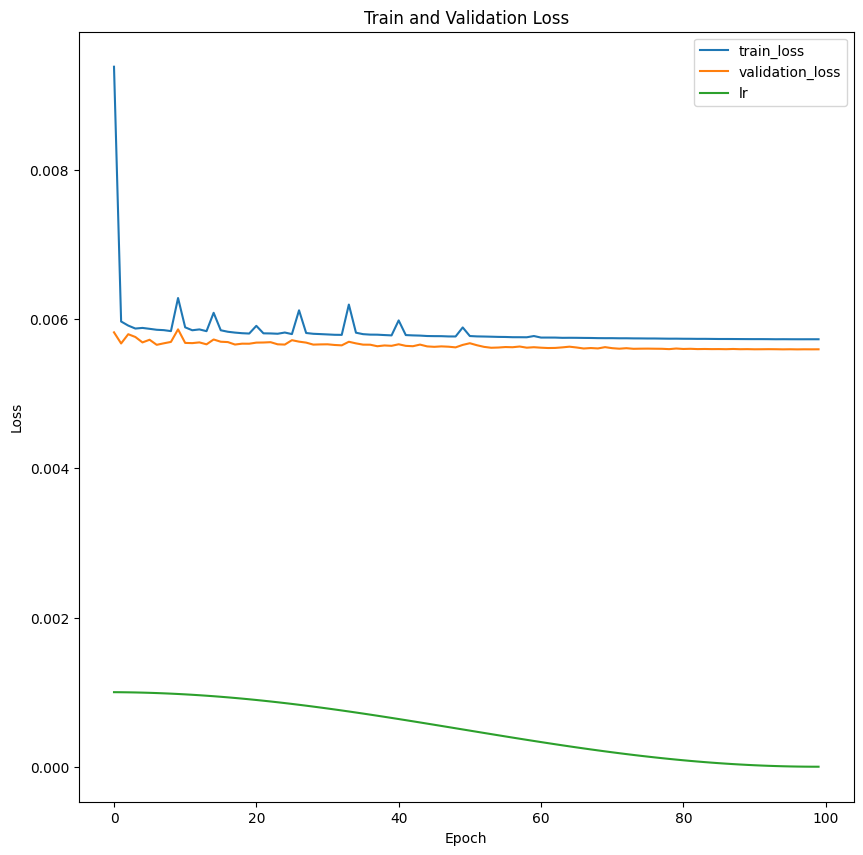

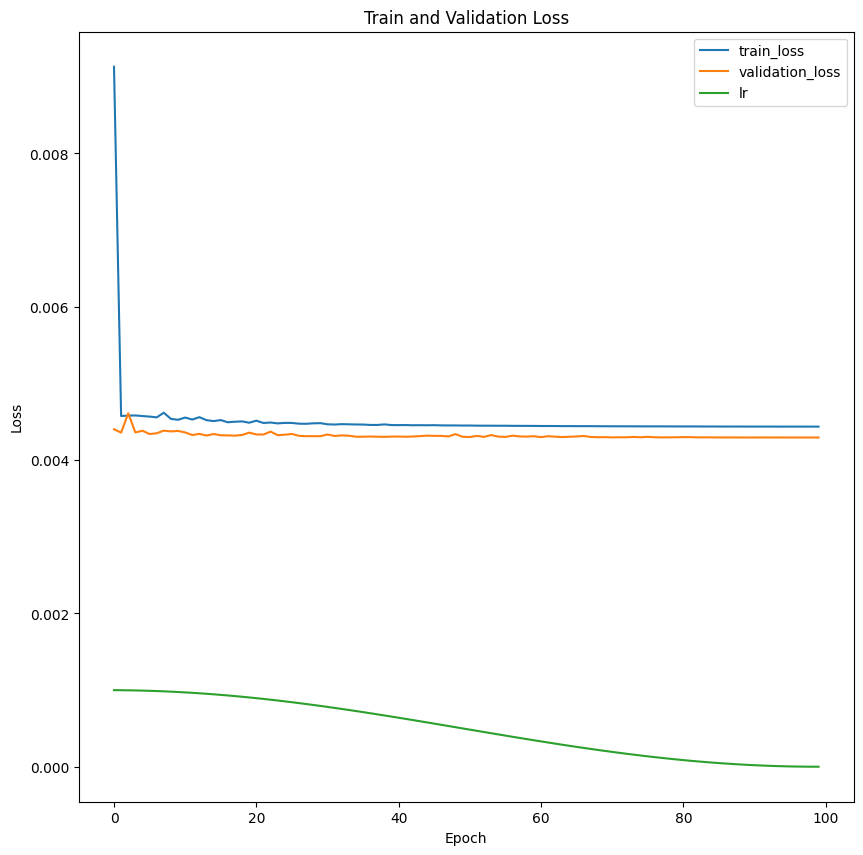

In [4]:
model_runner = ModelRunner(device=device)

model_runner.plot_train_validation_loss_from_df(df_with_noise)
model_runner.plot_train_validation_loss_from_df(df_without_noise)


In [5]:
model_runner.compare_models(
    [
        {"name": "DBPN with noise", "model": model_with_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
        {"name": "DBPN without noise", "model": model_without_noise,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN with noise,24.476372,0.600177
DBPN without noise,24.850704,0.653421
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


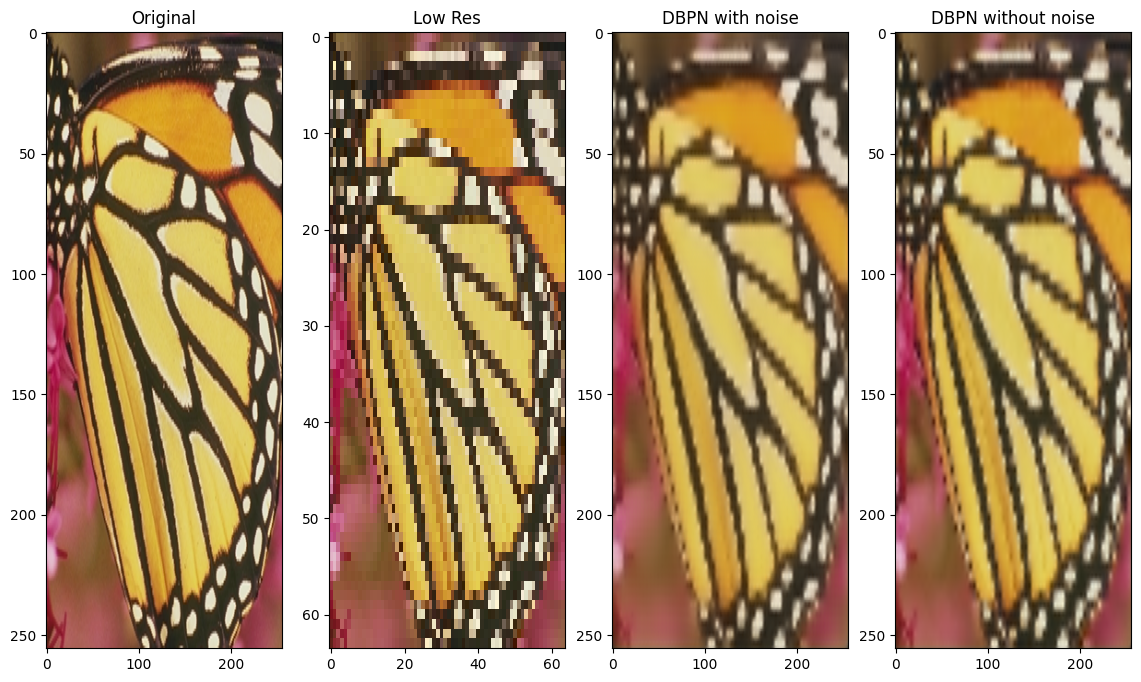

In [6]:
IMAGE_EXAMPLE = "../../datasets/Set5/butterfly.png"
image_helper = ImageHelper()
image_helper.show_tensor_as_images_side_by_side(
    [
        {
            "label": "Original",
            "tensor": image_helper.image_to_tensor(IMAGE_EXAMPLE),
        },
        {
            "label": "Low Res",
            "tensor": image_helper.downsample_image_as_tensor(
                IMAGE_EXAMPLE, 4, interpolation=Image.BICUBIC,
            ),
        },
        {
            "label": "DBPN with noise",
            "tensor": image_helper.apply_model_to_image(
                model_with_noise.to('cpu'),
                IMAGE_EXAMPLE,
                4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
        {
            "label": "DBPN without noise",
            "tensor": image_helper.apply_model_to_image(
                model_without_noise.to('cpu'),
                IMAGE_EXAMPLE,
                4,
                should_upsample=False,
                unsqueeze=True,
                device='cpu'
            )
        },
    ],
)